In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt

In [5]:
df = pd.read_csv(r'hospital_readmissions.csv')

In [6]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

age
['[70-80)' '[50-60)' '[60-70)' '[40-50)' '[80-90)']
6

time_in_hospital
[8 3 5 2 1]
14

n_lab_procedures
[72 34 45 36 42]
109

n_procedures
[1 2 0 6 3]
7

n_medications
[18 13 12  7 10]
70

n_outpatient
[2 0 1 3 7]
23

n_inpatient
[0 2 3 1 6]
16

n_emergency
[ 0  1 10  2  3]
21

medical_specialty
['Missing' 'Other' 'InternalMedicine' 'Family/GeneralPractice'
 'Cardiology']
7

diag_1
['Circulatory' 'Other' 'Injury' 'Digestive' 'Respiratory']
8

diag_2
['Respiratory' 'Other' 'Circulatory' 'Injury' 'Diabetes']
8

diag_3
['Other' 'Circulatory' 'Diabetes' 'Respiratory' 'Injury']
8

glucose_test
['no' 'normal' 'high']
3

A1Ctest
['no' 'normal' 'high']
3

change
['no' 'yes']
2

diabetes_med
['yes' 'no']
2

readmitted
['no' 'yes']
2



In [7]:
df['readmitted'] = df['readmitted'].apply(lambda x: x == 'yes')

for col in df.select_dtypes(object):
    df[col] = df[col].astype('category')


In [8]:
df.iloc[:, :-1] \
    .select_dtypes(np.number) \
    .corr() \
    .unstack() \
    .sort_values(ascending=False) \
    .drop_duplicates()[:5]

time_in_hospital  time_in_hospital    1.000000
                  n_medications       0.449415
n_medications     n_procedures        0.368681
n_lab_procedures  time_in_hospital    0.328326
                  n_medications       0.271741
dtype: float64

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score

numerical = [col for col in df.select_dtypes(np.number)]
categorical = categorical_columns = [col for col in df.select_dtypes('category')]

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['readmitted'].values
y_val = df_val['readmitted'].values
y_test = df_test['readmitted'].values

df_train = df_train.drop(['readmitted'], axis=1)
df_val = df_val.drop(['readmitted'], axis=1)
df_test = df_test.drop(['readmitted'], axis=1)

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))

time_in_hospital, 0.533
n_lab_procedures, 0.518
n_procedures, 0.526
n_medications, 0.537
n_outpatient, 0.544
n_inpatient, 0.603
n_emergency, 0.535


In [10]:
def mutual_score(series):
    return mutual_info_score(series, df_full_train.readmitted)

mi = df_full_train[categorical].apply(mutual_score)
mi_sorted = mi.sort_values(ascending=False)
mi_sorted

diabetes_med         0.002028
medical_specialty    0.001625
diag_1               0.001374
age                  0.001209
diag_3               0.000998
change               0.000982
diag_2               0.000611
A1Ctest              0.000423
glucose_test         0.000122
dtype: float64

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

columns = categorical + numerical

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(C=0.1, max_iter=10_000, solver='saga')
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dict = df_test[columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.646975038822293

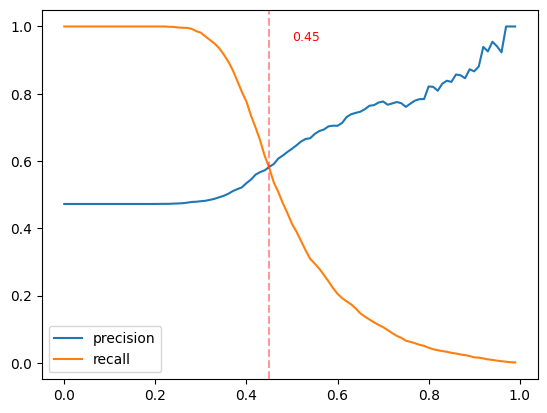

In [12]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.arange(0, 1, 0.01)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

df_scores = confusion_matrix_dataframe(y_val, y_pred)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)


plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.axvline(x = 0.45, color = 'r', linestyle='--', alpha=0.4)
plt.text(0.5, 0.95, '0.45', color='r', fontsize=9, verticalalignment='bottom', horizontalalignment='left')

plt.legend()
plt.show()

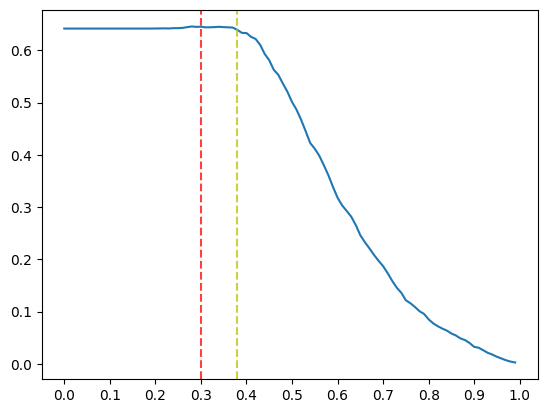

In [13]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

plt.plot(df_scores.threshold, df_scores.f1)
plt.xticks(np.linspace(0,1,11))
plt.axvline(x = 0.30, color = 'r', linestyle='--', alpha=0.75)
plt.axvline(x = 0.38, color = 'y', linestyle='--', alpha=0.75)
plt.show()
     

In [14]:
from sklearn.model_selection import KFold

def train(df_train, y_train, C=0.1):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

scores = []

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.readmitted
    y_val = df_val.readmitted

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'{np.mean(scores).round(4)}, {np.std(scores).round(4)}')

0.6439, 0.0146


In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.readmitted
        y_val = df_val.readmitted

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C={C} {np.mean(scores).round(4)}, {np.std(scores).round(4)}')

C=0.01 0.6453, 0.008
C=0.1 0.6444, 0.0071
C=1 0.6439, 0.007
C=10 0.6438, 0.007


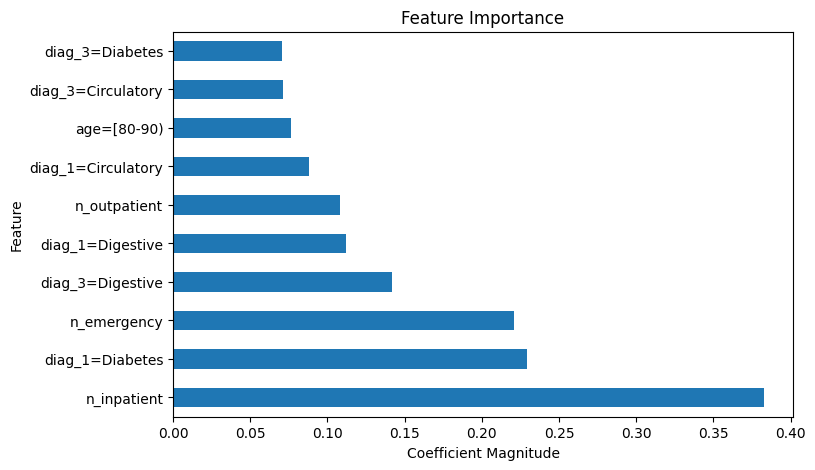

In [16]:
# Get feature importances
model_coef = model.coef_[0]
feature_names = dv.get_feature_names_out()
feature_importance = pd.Series(model_coef, index=feature_names)

# Plot feature importances
plt.figure(figsize=(8, 5))
feature_importance.nlargest(10).plot(kind='barh')
plt.title(f'Feature Importance')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.show()

In [17]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [18]:
# Best Estimator - No Tuning

def model_pipeline(df , estimator, **params):

    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train['readmitted'].values
    y_val = df_val['readmitted'].values
    y_test = df_test['readmitted'].values

    df_train = df_train.drop(['readmitted'], axis=1)
    df_val = df_val.drop(['readmitted'], axis=1)
    df_test = df_test.drop(['readmitted'], axis=1)

    categorical_cols = ['glucose_test', 'A1Ctest']
    ordinal_cols = ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'change', 'diabetes_med']

    model = Pipeline(steps=[
                ('transf_cols', make_column_transformer(
                    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
                    (OrdinalEncoder(), ordinal_cols),
                    remainder='passthrough'
                )),
                ('model', estimator(**params))
             ])
    model.fit(df_train, y_train)
    y_pred = model.predict_proba(df_test)[:, 1]

    score= roc_auc_score(y_test, y_pred).round(4)
    print(f'\n AUC score: {score:.4f}')
    
    return score

In [19]:
print(model_pipeline(df, LogisticRegression, max_iter=1_000, C=0.3))
print(model_pipeline(df, DecisionTreeClassifier))
print(model_pipeline(df, RandomForestClassifier))


 AUC score: 0.6427
0.6427

 AUC score: 0.5296
0.5296

 AUC score: 0.6296
0.6296


In [20]:
def preprocessing(df):

    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

    # Reset the indices of the dataframes
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Separate the target variable
    y_train = df_train['readmitted'].values
    y_val = df_val['readmitted'].values
    y_test = df_test['readmitted'].values

    # Drop the target variable from the data
    df_train = df_train.drop(['readmitted'], axis=1)
    df_val = df_val.drop(['readmitted'], axis=1)
    df_test = df_test.drop(['readmitted'], axis=1)

    categorical_cols = ['glucose_test', 'A1Ctest']
    ordinal_cols = ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'change', 'diabetes_med']

    all_cols = categorical_cols + ordinal_cols

    # Create a column transformer for preprocessing
    preprocessor = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
         (OrdinalEncoder(), ordinal_cols),
        remainder='passthrough'
    )
    
    X_train = preprocessor.fit_transform(df_train)
    X_val = preprocessor.transform(df_val)

    return X_train, X_val, y_train, y_val, preprocessor


In [21]:
X_train, X_val, y_train, y_val, dv  = preprocessing(df)

mdl = xgb.XGBClassifier()

mdl.fit(X_train, y_train)

y_pred = mdl.predict_proba(X_val)[:, 1]

roc_auc_score(y_val, y_pred)

0.6336635180861492

In [22]:
# Create DMatrix objects for XGBoost
X_train, X_val, y_train, y_val, dv  = preprocessing(df)

feature_names = dv.get_feature_names_out()
feature_names = [name.replace('[', '_').replace(']', '_').replace('<', '_') for name in feature_names]

dtrain_clf = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval_clf = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 5,
    'objective': 'binary:logistic',
    'seed': 1,
    'verbosity': 2,
    'gamma':1,
    'eval_metric': 'auc'
}


# Train the XGBoost model
model = xgb.train(params, dtrain_clf, num_boost_round=105)

# Predict using the trained model
y_pred = model.predict(dval_clf)
print(roc_auc_score(y_val, y_pred).round(4))

0.6601


#### Complete code - Xgboost

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
The best params are: {'eta': 0.1, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.8, 'eval_metric': 'auc'}
[0]	train-auc:0.62922	val-auc:0.62826
[20]	train-auc:0.65618	val-auc:0.65323
[40]	train-auc:0.66842	val-auc:0.65929
[60]	train-auc:0.67654	val-auc:0.66323
[80]	train-auc:0.68315	val-auc:0.66462
[100]	train-auc:0.68797	val-auc:0.66383
[105]	train-auc:0.68977	val-auc:0.66369


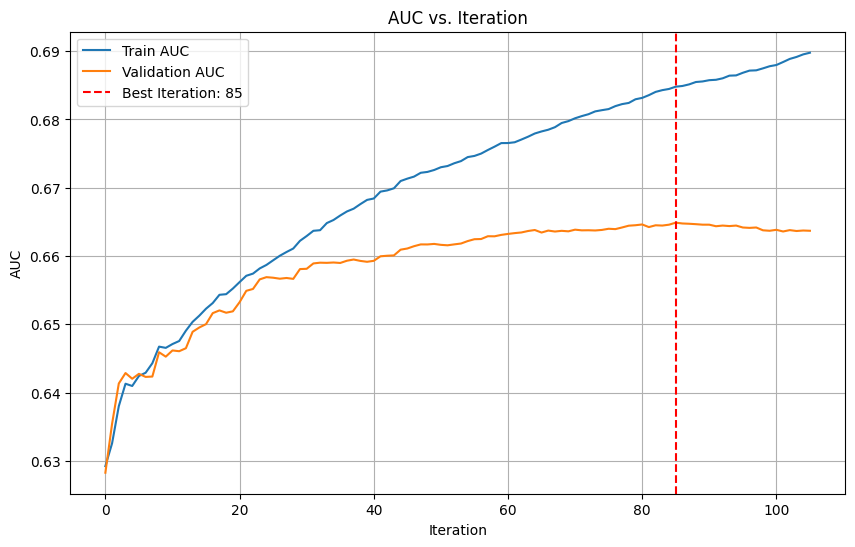

<Figure size 640x480 with 0 Axes>

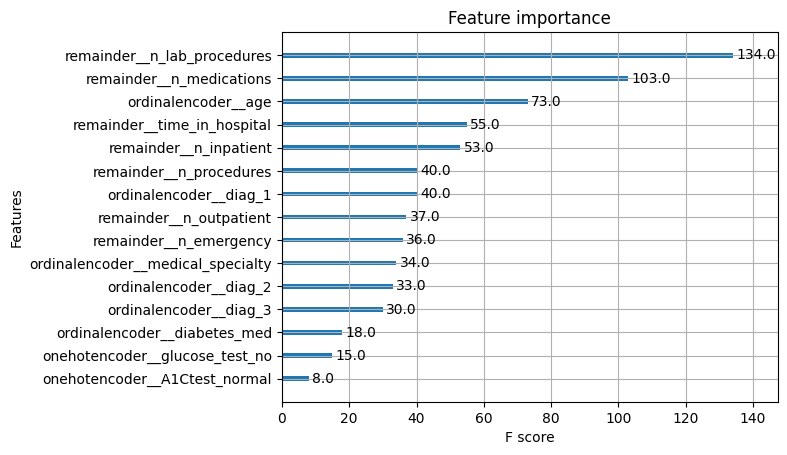

0.6637


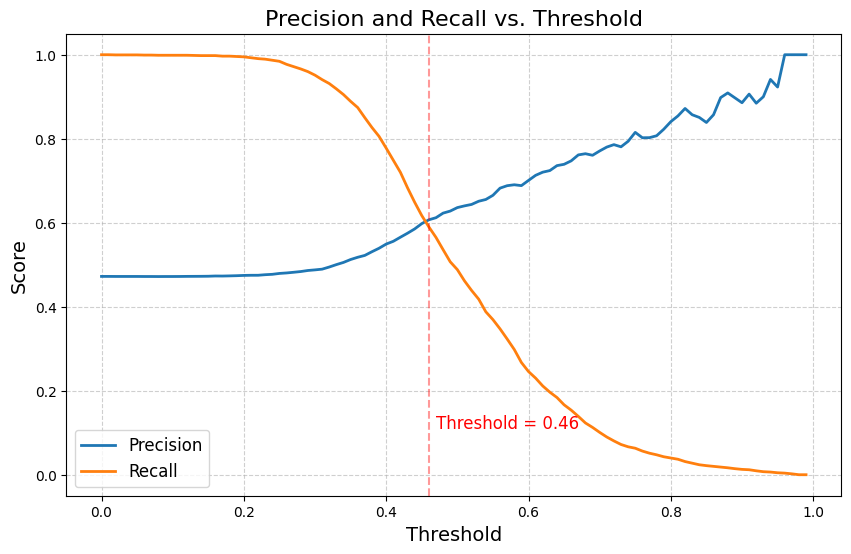

AUC on fold 1 is 0.6707676864311851
AUC on fold 2 is 0.634589004324052
AUC on fold 3 is 0.6612930305598534
AUC on fold 4 is 0.6406349660580937
AUC on fold 5 is 0.6571796686591698
AUC on fold 6 is 0.6785359340496682
AUC on fold 7 is 0.6636754701880753
AUC on fold 8 is 0.6681990821570815
AUC on fold 9 is 0.6423642826486481
AUC on fold 10 is 0.6634034259737743
Validation results:
Mean AUC: 0.658 +/- 0.014
Final model AUC on the test set: 0.657
The model is saved to xgb_eta01.bin


In [24]:
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score

import pickle

# Load the dataset
df = pd.read_csv(r'hospital_readmissions.csv')

df['readmitted'] = df['readmitted'].apply(lambda x: x == 'yes')

for col in df.select_dtypes(include='object'):
    df[col] = df[col].astype('category')

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

# Reset the indices of the dataframes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Separate the target variable
y_train = df_train['readmitted'].values
y_val = df_val['readmitted'].values
y_test = df_test['readmitted'].values

# Drop the target variable from the data
df_train = df_train.drop(['readmitted'], axis=1)
df_val = df_val.drop(['readmitted'], axis=1)
df_test = df_test.drop(['readmitted'], axis=1)

categorical_cols = ['glucose_test', 'A1Ctest']
ordinal_cols = ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'change', 'diabetes_med']

# Create a column transformer for preprocessing
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    (OrdinalEncoder(), ordinal_cols),
    remainder='passthrough'
)

X_train = preprocessor.fit_transform(df_train)
X_val = preprocessor.transform(df_val)

feature_names = preprocessor.get_feature_names_out()
feature_names = [name.replace('[', '_').replace(']', '_').replace('<', '_') for name in feature_names]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

param_grid = {
    'eta': [0.1, 0.01, 0.001],  # Learning rate
    'max_depth': [3, 4, 5],    # Maximum tree depth
    'min_child_weight': [10, 15, 20],
    'subsample': [0.7, 0.8, 0.9, 1.0],
     'gamma': [0, 0.1, 0.2, 0.3] # Minimum sum of instance weight (hessian) needed in a child
}

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    seed=1,
    verbosity=2
)

# Create the grid search object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',  # Use ROC AUC as the evaluation metric
    cv=3,
    verbose=1
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parametes
params = grid_search.best_params_
params['eval_metric'] = 'auc'
print(f'The best params are: {params}')

# Train the XGBoost model and find the best iteration
evals_result = {}
watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(params, dtrain, evals=watchlist, num_boost_round=300, evals_result=evals_result, verbose_eval=20, early_stopping_rounds=20)

best_num_boost_round = model.best_iteration

# Plot the AUC values during training
train_auc = evals_result['train']['auc']
val_auc = evals_result['val']['auc']
best_iteration = model.best_iteration

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(train_auc, label='Train AUC')
plt.plot(val_auc, label='Validation AUC')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.title('AUC vs. Iteration')
plt.axvline(x=best_iteration, color='r', linestyle='--', label=f'Best Iteration: {best_iteration}')
plt.legend()
plt.grid()
plt.show()
plt.clf()  



plot_importance(model, max_num_features = 15)
plt.show()

# Predict using the trained model on the validation set
y_pred = model.predict(dval)
print(roc_auc_score(y_val, y_pred).round(4))

def confusion_matrix_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.arange(0, 1, 0.01)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['Threshold', 'True Positive', 'False Positive', 'False Negative', 'True Negative']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['Precision'] = df_scores['True Positive'] / (df_scores['True Positive'] + df_scores['False Positive'])
    df_scores['Recall'] = df_scores['True Positive'] / (df_scores['True Positive'] + df_scores['False Negative'])

    return df_scores

df_scores = confusion_matrix_dataframe(y_val, y_pred)

plt.figure(figsize=(10, 6))

plt.plot(df_scores['Threshold'], df_scores['Precision'], label='Precision', linewidth=2)
plt.plot(df_scores['Threshold'], df_scores['Recall'], label='Recall', linewidth=2)

threshold_value = 0.46  # Set the threshold value you want to highlight
plt.axvline(x=threshold_value, color='r', linestyle='--', alpha=0.4)
plt.text(threshold_value + 0.01, 0.1, f'Threshold = {threshold_value}', color='r', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Precision and Recall vs. Threshold', fontsize=16)
plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
     
# Define a train function for later use
def train(X, y, params, num_boost_round, feature_names):
    X_transformed = preprocessor.transform(X)
    dtrain = xgb.DMatrix(X_transformed, label=y, feature_names=feature_names)
    model = xgb.train(params, dtrain, num_boost_round=best_num_boost_round)
    return model

# Define a predict function for later use
def predict(X, preprocessor, model, feature_names):
    X_transformed = preprocessor.transform(X)
    X_Dmat = xgb.DMatrix(X_transformed, feature_names=feature_names)
    y_pred = model.predict(X_Dmat)
    return y_pred

kfold = KFold(n_splits=10, shuffle=True, random_state=1)
scores = []

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = df_train['readmitted'].values
    y_val = df_val['readmitted'].values
    model = train(df_train, y_train, params, best_num_boost_round, feature_names)
    y_pred = predict(df_val, preprocessor, model, feature_names)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print(f'AUC on fold {fold+1} is {auc}')

print('Validation results:')
print(f'Mean AUC: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

# Train the final model on the full training data
model = train(df_full_train, df_full_train['readmitted'].values, params, best_num_boost_round, feature_names)

# Predict on the test set using the final model
y_pred = predict(df_test, preprocessor, model, feature_names)
auc = roc_auc_score(y_test, y_pred)
print(f'Final model AUC on the test set: {auc:.3f}')

# Save the preprocessor and model to a binary file
output_file = 'xgb_eta01.bin'
with open(output_file, 'wb') as f_out:
    pickle.dump((preprocessor, model), f_out)

print(f'The model is saved to {output_file}')


#### Complete code - Logistic

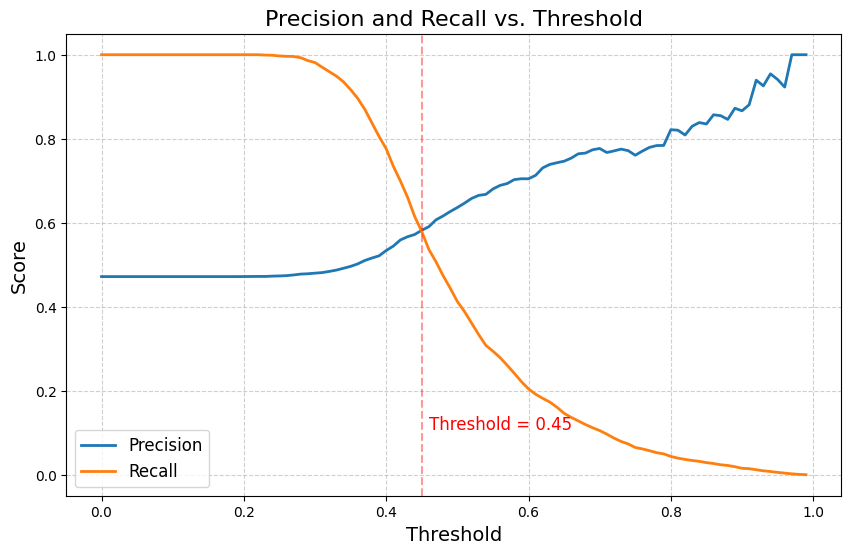

C=0.01 0.6453, 0.008
C=0.1 0.6444, 0.0071
C=1 0.6439, 0.007
C=10 0.6438, 0.007
training the final model
auc=0.6483967321634767
the model is saved to logistic_C_0.1


In [25]:
import pandas as pd
import xgboost as xgb
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score


# Load the dataset
df = pd.read_csv(r'hospital_readmissions.csv')

df['readmitted'] = df['readmitted'].apply(lambda x: x == 'yes')

for col in df.select_dtypes(include='object'):
    df[col] = df[col].astype('category')

numerical = [col for col in df.select_dtypes(np.number)]
categorical = categorical_columns = [col for col in df.select_dtypes('category')]

columns = numerical + categorical

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

# Reset the indices of the dataframes
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Separate the target variable
y_train = df_train['readmitted'].values
y_val = df_val['readmitted'].values
y_test = df_test['readmitted'].values

# Drop the target variable from the data
df_train = df_train.drop(['readmitted'], axis=1)
df_val = df_val.drop(['readmitted'], axis=1)
df_test = df_test.drop(['readmitted'], axis=1)

train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(C=0.1, max_iter=10_000, solver='saga')
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dict = df_test[columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)


def confusion_matrix_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.arange(0, 1, 0.01)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['Threshold', 'True Positive', 'False Positive', 'False Negative', 'True Negative']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['Precision'] = df_scores['True Positive'] / (df_scores['True Positive'] + df_scores['False Positive'])
    df_scores['Recall'] = df_scores['True Positive'] / (df_scores['True Positive'] + df_scores['False Negative'])

    return df_scores

df_scores = confusion_matrix_dataframe(y_val, y_pred)

plt.figure(figsize=(10, 6))

plt.plot(df_scores['Threshold'], df_scores['Precision'], label='Precision', linewidth=2)
plt.plot(df_scores['Threshold'], df_scores['Recall'], label='Recall', linewidth=2)

threshold_value = 0.45  # Set the threshold value you want to highlight
plt.axvline(x=threshold_value, color='r', linestyle='--', alpha=0.4)
plt.text(threshold_value + 0.01, 0.1, f'Threshold = {threshold_value}', color='r', fontsize=12, verticalalignment='bottom', horizontalalignment='left')

plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Precision and Recall vs. Threshold', fontsize=16)
plt.legend(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


def train(df_train, y_train, C=0.1):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.readmitted
        y_val = df_val.readmitted

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f'C={C} {np.mean(scores).round(4)}, {np.std(scores).round(4)}')

# Final Model
print('training the final model')
dv, model = train(df_full_train, df_full_train.readmitted.values, C=0.01)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print(f'auc={auc}')

output_file = 'logistic_C_0.1'
# Save the model
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

print(f'the model is saved to {output_file}')
